# ANALYTICAL FINANCE 2
## Project : Use data for SOFR on FRED to bootstrap a SOFR Swap-curve using Python.

This project aims to bootstrap a SOFR Swap-curve using using Python.

In [1]:
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from datetime import datetime

In [2]:
API_KEY = pd.read_csv('.API_KEY.txt',sep=';', header=None)[1][0]
BASE_URL = 'https://api.stlouisfed.org/fred/series/observations'
series_ids_bootstrap = {

                        # SHORT TERM RATES
                        'SOFRINDEX': 'SOFR Index accumulated',
                        'SOFR': 'SOFR Index',
                        'FEDFUNDS': 'Effective Federal Funds Rate',
                        'RIFSPPFAAD07NB': '1-Week Treasury Constant Maturity Rate',
                        'TY1MCD': '1-Month Certificate of Deposit Rate',
                        'RIFSPPFAAD60NB': '2-Month Commercial Paper Rate',
                        'IR3TCD01USQ156N': '3-Month Certificate of Deposit Rate',

                        # # MEDIUM TERM RATES
                        # 'THREEFF1': 'Fitted Instantaneous Forward Rate 1 Year Hence',
                        # 'THREEFF2': 'Fitted Instantaneous Forward Rate 2 Years Hence',
}

def fetch_data(series_id):
    params = {
        'series_id': series_id,
        'api_key': API_KEY,
        'file_type': 'json',
        'frequency': 'd',  # daily frequency
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Series {series_id} not available at daily frequency, trying monthly")
        params = {
        'series_id': series_id,
        'api_key': API_KEY,
        'file_type': 'json',
        'frequency': 'm',  # monthly frequency
        }
        response = requests.get(BASE_URL, params=params)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Series {series_id} not available at monthly frequency")
            params = {
            'series_id': series_id,
            'api_key': API_KEY,
            'file_type': 'json',
            'frequency': 'q',  # quarterly frequency
            }
            response = requests.get(BASE_URL, params=params)
            if response.status_code == 200:
                return response.json()
            else:
                print(f"Series {series_id} not available at quarterly frequency")
                params = {
                'series_id': series_id,
                'api_key': API_KEY,
                'file_type': 'json',
                'frequency': 'a',  # annual frequency
                }
                response = requests.get(BASE_URL, params=params)
                if response.status_code == 200:
                    return response.json()
                else:
                    print(f"Error fetching {series_id}: {response.status_code}")
        return None

data = {name: fetch_data(series_id) for series_id, name in series_ids_bootstrap.items()}
for name, content in data.items():
    if content:
        print(f"{name} retrieved")  
    else:
        print(f"{name}: No data retrieved")

def convert_to_df(content):
    if content:
        try:
            df = pd.DataFrame(content['observations'])
            df['date'] = pd.to_datetime(df['date'])
            df['value'].replace('.', np.nan, inplace=True)
            df['value'] = pd.to_numeric(df['value'])
            df = df.set_index('date')
            return df
        except Exception as e:
            print(f"Error converting to DataFrame: {e}")
            return None
    else:
        return None
    
dfs = {name: convert_to_df(content) for name, content in data.items()}
dfs = {name: content for name, content in dfs.items() if content is not None}

fic_data = []
fic_data.extend(df.value for df in dfs.values())
fic_data = pd.concat(fic_data, axis=1)
fic_data.columns = dfs.keys()
fic_data.ffill(inplace=True)
fic_data.dropna(inplace=True)

fic_data['day_o_n'] = fic_data.index.dayofweek == 4
fic_data['day_o_n'] = fic_data['day_o_n'].astype(int)
fic_data['day_o_n'] = fic_data['day_o_n'].replace(1, 3)
fic_data.loc[fic_data['day_o_n'] == 0, 'day_o_n'] = 1


yield_curve_rate = pd.read_csv('data/yield-curve-rates-1990-2023.csv', sep=',')
yield_curve_rate['Date'] = pd.to_datetime(yield_curve_rate['Date'])
yield_curve_rate.set_index('Date', inplace=True)
yield_curve_rate.sort_index(inplace=True)

fic_data = pd.merge(fic_data, yield_curve_rate, left_index=True, right_index=True, how='inner')
fic_data.tail(5)

Series FEDFUNDS not available at daily frequency, trying monthly
Series TY1MCD not available at daily frequency, trying monthly
Series IR3TCD01USQ156N not available at daily frequency, trying monthly
Series IR3TCD01USQ156N not available at monthly frequency
SOFR Index accumulated retrieved
SOFR Index retrieved
Effective Federal Funds Rate retrieved
1-Week Treasury Constant Maturity Rate retrieved
1-Month Certificate of Deposit Rate retrieved
2-Month Commercial Paper Rate retrieved
3-Month Certificate of Deposit Rate retrieved


,SOFR Index accumulated,SOFR Index,Effective Federal Funds Rate,1-Week Treasury Constant Maturity Rate,1-Month Certificate of Deposit Rate,2-Month Commercial Paper Rate,3-Month Certificate of Deposit Rate,day_o_n,1 Mo,2 Mo,...,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
2023-12-22,1.113454,5.32,5.33,5.33,5.56,5.42,5.396667,3,5.54,5.52,...,5.45,5.31,4.82,4.31,4.04,3.87,3.92,3.90,4.21,4.05
2023-12-26,1.114112,5.35,5.33,5.33,5.56,5.42,5.396667,1,5.53,5.52,...,5.44,5.28,4.83,4.26,4.05,3.89,3.91,3.89,4.20,4.04
2023-12-27,1.114278,5.39,5.33,5.31,5.56,5.42,5.396667,1,5.55,5.53,...,5.42,5.26,4.79,4.20,3.97,3.78,3.81,3.79,4.10,3.95
2023-12-28,1.114445,5.40,5.33,5.31,5.56,5.42,5.396667,1,5.57,5.55,...,5.42,5.28,4.82,4.26,4.02,3.83,3.84,3.84,4.14,3.98
2023-12-29,1.114612,5.38,5.33,5.31,5.56,5.42,5.396667,3,5.60,5.59,...,5.41,5.26,4.79,4.23,4.01,3.84,3.88,3.88,4.20,4.03


Running test: short_term_ZC_curve
Results Discount : [1.000014389095932, 1.0000287783989101, 1.0001310695821937, 1.0005084388196208, 1.0008958322162296, 1.0012284169137755]
Results Zero Rate : [-0.5251982229668734, -0.5251982229668734, -0.6833894652022674, -0.5622212335329413, -0.5271490117426257, -0.492414291068221]


Running test: mid_term_ZC_curve
Results Discount : [1.0020695695909323, 1.0034113256410722, 1.0042973111495388, 1.004942540090418, 1.0052957619263236, 1.0053821689382874, 1.0051382553883133, 1.0046024395149487, 1.003765132100588, 1.0026246465651203]
Results Zero Rate : [-0.48372583872428027, -0.5032448980045241, -0.4630644933779173, -0.41948334045735036, -0.37074093689741744, -0.3206585830102614, -0.26647597635596776, -0.21135390246270125, -0.15516883849883567, -0.09802674091206523]




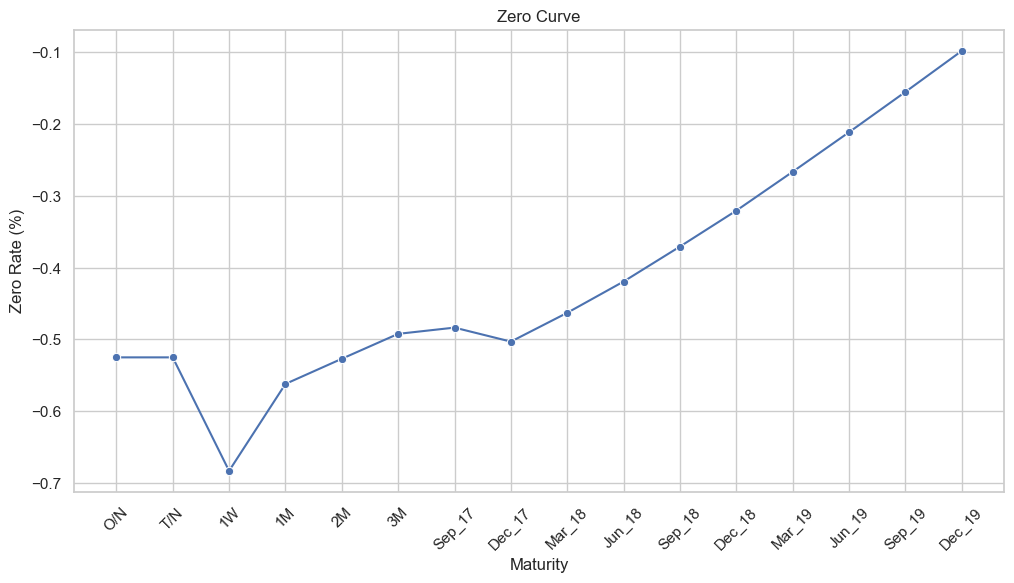

In [3]:
import unittest
from datetime import datetime
from math import log
import numpy as np

terms_short = [1, 1, 7, 33, 62, 91]
quoted_rates_short = [-0.00518, -0.00518, -0.00526, -0.00523, -0.00503, -0.00474]
start_date_short_str = [
    "2017-07-17", "2017-07-18", "2017-07-19", "2017-07-19",
    "2017-07-19", "2017-07-19"
]
maturity_short_str = [
    "2017-07-18", "2017-07-19", "2017-07-26", "2017-08-21",
    "2017-09-19", "2017-10-19"
]
discount_maturities_name_short = ["O/N", "T/N", "1W", "1M", "2M", "3M"]

start_date_short = [datetime.strptime(date_str, "%Y-%m-%d").date() for date_str in start_date_short_str]
maturity_short = [datetime.strptime(date_str, "%Y-%m-%d").date() for date_str in maturity_short_str]

# Medium term data setup (Sep_17 to Dec_19)
terms_mid = [91, 91, 91, 91, 91, 91, 91, 91, 91, 91]
quoted_rates_mid = [-0.00459, -0.00529, -0.00349, -0.00254, -0.00139, -0.00034, 0.00096, 0.00211, 0.0033, 0.0045]

start_date_mid_str = [
    "2017-09-20", "2017-12-20", "2018-03-21", "2018-06-20", "2018-09-19",
    "2018-12-19", "2019-03-20", "2019-06-19", "2019-09-18", "2019-12-18", 
    "2020-03-19"
]
maturity_mid_str = [
    "2017-12-20", "2018-03-21", "2018-06-20", "2018-09-19", "2018-12-19",
    "2019-03-20", "2019-06-19", "2019-09-18", "2019-12-18", 
    "2020-03-18" # ADD A DATE TO BE ABLE TO ITER ON THE LAST TERM
]
discount_maturities_name_mid = ["Sep_17", "Dec_17", "Mar_18", "Jun_18", "Sep_18", "Dec_18", "Mar_19", "Jun_19", "Sep_19", "Dec_19"]

start_date_mid = [datetime.strptime(date_str, "%Y-%m-%d").date() for date_str in start_date_mid_str]
maturity_mid = [datetime.strptime(date_str, "%Y-%m-%d").date() for date_str in maturity_mid_str]

def calculate_discount_factor(rate, period_days, base_discount_factor=1):
    return base_discount_factor / (1 + rate * (period_days / 360))

def calculate_zero_rate(discount_factor, period_days):
    return -100 * (log(discount_factor) / (period_days / 365))

def short_term_ZC_curve(terms, quoted_rates, start_date_short_str, maturity_short_str):
    ZC_short = []
    D_short = []
    
    bus_day = [np.busday_count(start_date_short_str[i], maturity_short_str[i]) for i in range(len(start_date_short_str))]
    
    D_ON = calculate_discount_factor(quoted_rates[0], terms[0])
    Z_ON = calculate_zero_rate(D_ON, terms[0])
    
    D_TN = D_ON / (1 + (quoted_rates[1] * terms[1]) / 360)
    Z_TN = calculate_zero_rate(D_ON, terms[1])
    
    ZC_short.extend([Z_ON, Z_TN])
    D_short.extend([D_ON, D_TN])

    for i in range(2, len(start_date_short_str)):
        if bus_day[i] == 0:
            D_i = calculate_discount_factor(quoted_rates[i], terms[i])
        if bus_day[i] == 1:
            D_i = D_ON / (1 + quoted_rates[i] * (terms[i] / 360))
        else:
            D_i = D_TN / (1 + quoted_rates[i] * (terms[i] / 360))

        Z_i = calculate_zero_rate(D_i, terms[i])
        D_short.append(D_i)
        ZC_short.append(Z_i)

    return D_short, ZC_short

def mid_term_ZC_curve(terms, quoted_rates_short, quoted_rates_mid, t_short, maturity_short, maturity_short_str, start_date_short, start_date_short_str, start_date_mid):
    discount_factors = []
    zero_rates = []
    
    short_DF = short_term_ZC_curve(t_short, quoted_rates_short, start_date_short_str, maturity_short_str)

    t0 = maturity_short[-2]
    T = maturity_short[-1]
    t_stub = start_date_mid[0]
    start_date0 = start_date_short[0]

    D_t0 = short_DF[0][-2]
    D_T = short_DF[0][-1]
    D_stub = D_t0 + (D_T - D_t0) * ((t_stub - t0).days / (T - t0).days)
    z_stub = calculate_zero_rate(D_stub, (t_stub - start_date0).days) # Not used in the calculation

    D_i1 = D_stub / (1 + quoted_rates_mid[0] * (terms[0] / 360))
    Z_i1 = calculate_zero_rate(D_i1, (start_date_mid[1] - start_date0).days)
    
    discount_factors.append(D_i1)
    zero_rates.append(Z_i1)

    for i in range(1, len(terms)):
        start_i = start_date_mid[i + 1]
        D_im1 = discount_factors[-1]
        
        D_i = D_im1 / (1 + quoted_rates_mid[i] * (terms[i] / 360))
        Z_i = calculate_zero_rate(D_i, (start_i - start_date0).days)
        
        discount_factors.append(D_i)
        zero_rates.append(Z_i)

    return discount_factors, zero_rates

    
print("Running test: short_term_ZC_curve")
D_short, ZC_short = short_term_ZC_curve(
    terms_short,
    quoted_rates_short,
    start_date_short_str,
    maturity_short_str
)

print(f"Results Discount : {D_short}")
print(f"Results Zero Rate : {ZC_short}")
print('\n')

print("Running test: mid_term_ZC_curve")
D_mid, ZC_mid = mid_term_ZC_curve(
    terms_mid,
    quoted_rates_short,
    quoted_rates_mid,
    terms_short,
    maturity_short,
    maturity_short_str,
    start_date_short,
    start_date_short_str,
    start_date_mid
)

print(f"Results Discount : {D_mid}")
print(f"Results Zero Rate : {ZC_mid}")
print('\n')


# Concat short and mid term results to get the full curve
D_short.extend(D_mid)
ZC_short.extend(ZC_mid)

list_maturity_name = ['O/N', 'T/N', '1W', '1M', '2M', '3M', 'Sep_17', 'Dec_17', 'Mar_18', 'Jun_18', 'Sep_18', 'Dec_18', 'Mar_19', 'Jun_19', 'Sep_19', 'Dec_19']
short_medium_zc_df = pd.DataFrame({'Maturity': list_maturity_name, 'Discount Factor': D_short, 'Zero Rate (%)': ZC_short})

sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.lineplot(x='Maturity', y='Zero Rate (%)', data=short_medium_zc_df, marker='o')
plt.xticks(rotation=45)
plt.title('Zero Curve') 
plt.xlabel('Maturity')
plt.ylabel('Zero Rate (%)')
plt.show()

In [4]:
liste_date_totale = pd.Series([
    "2017-07-18", "2017-07-19", "2017-07-26", "2017-08-21", "2017-09-19", 
    "2017-10-19", "2017-12-20", "2018-03-21", "2018-06-20", "2018-09-19", 
    "2018-12-19", "2019-03-20", "2019-06-19", "2019-09-18", "2019-12-18", 
    "2020-03-18", "2020-07-20", "2021-07-19", "2022-07-19", "2023-07-19", 
    "2024-07-19", "2025-07-21", "2026-07-20", "2027-07-19", "2029-07-19", "2032-07-20", 
    "2037-07-19", "2042-07-21", "2047-07-19"
])

liste_date_totale = pd.to_datetime(liste_date_totale)

start_date = pd.to_datetime("2017-07-17")
days_from_start_via_seconds = (liste_date_totale - start_date).apply(lambda x: x.total_seconds() / 86400)
days_from_start_via_seconds

0         1.0
1         2.0
2         9.0
3        35.0
4        64.0
5        94.0
6       156.0
7       247.0
8       338.0
9       429.0
10      520.0
11      611.0
12      702.0
13      793.0
14      884.0
15      975.0
16     1099.0
17     1463.0
18     1828.0
19     2193.0
20     2559.0
21     2926.0
22     3290.0
23     3654.0
24     4385.0
25     5482.0
26     7307.0
27     9135.0
28    10959.0
dtype: float64

In [5]:
import pandas as pd
import math

# The data provided (from the book Analytical Finance II)
data = {
    "Tenor": [
        "O/N", "T/N", "1W", "1M", "2M", "3M", "Sep_17", "Dec_17",
        "Mar_18", "Jun_18", "Sep_18", "Dec_18", "Mar_19", "Jun_19",
        "Sep_19", "Dec_19", "3Y", "4Y", "5Y", "6Y", "7Y", "8Y", 
        "9Y", "10Y", "12Y", "15Y", "20Y", "25Y", "30Y"
    ],
    "Period days": [
        1, 1, 7, 33, 62, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,
        1097, 1461, 1826, 2191, 2557, 2924, 3288, 3652, 4383, 5479,
        7306, 9133, 10957
    ],
    "Quote rate": [
        -0.00518, -0.00518, -0.00526, -0.00523, -0.00503, -0.00474,
        -0.00459, -0.00529, -0.00349, -0.00254, -0.00139, -0.00034,
        0.00096, 0.00211, 0.00330, 0.00450, -0.00125, 0.002225,
        0.004575, 0.006700, 0.008575, 0.010225, 0.011650, 0.012875,
        0.014850, 0.017075, 0.019175, 0.019975, 0.020275
    ]
}

# Use only data starting from 3Y (index 16 onward)
swap_terms = [3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]
swap_rates = data["Quote rate"][16:]  # Only take rates starting from 3Y (index 16 onward)
swap_rates_dict = dict(zip(swap_terms, swap_rates))

# Facteurs d'actualisation existants à partir du bootstrapping précédent (pour 1 an et 2 ans)
D_1Y = 1.004503375
D_2Y = 1.004962055

D_t_dict = {0: 1.0, 1: D_1Y, 2: D_2Y}
Z_t_dict = {}

Z_t_dict[1] = (math.log(D_t_dict[1]) / 1) * 100
Z_t_dict[2] = (math.log(D_t_dict[2]) / 2) * 100

available_terms = sorted(swap_rates_dict.keys())
available_rates = [swap_rates_dict[t] for t in available_terms]

def interpolate_swap_rate(T):
    for i in range(len(available_terms) - 1):
        T1 = available_terms[i]
        T2 = available_terms[i + 1]
        if T1 <= T <= T2:
            r1 = swap_rates_dict[T1]
            r2 = swap_rates_dict[T2]
            r_T = r1 + (r2 - r1) * (T - T1) / (T2 - T1)
            return r_T
    T1 = available_terms[-2]
    T2 = available_terms[-1]
    r1 = swap_rates_dict[T1]
    r2 = swap_rates_dict[T2]
    r_T = r1 + (r2 - r1) * (T - T1) / (T2 - T1)
    return r_T

for T in swap_terms:  
    r_T_par = swap_rates_dict[T]
    
    for t in range(3, T):
        if t not in D_t_dict:
            known_terms = sorted(Z_t_dict.keys())
            if t in known_terms:
                Z_t = Z_t_dict[t]
            else:
                for i in range(len(known_terms) - 1):
                    t1 = known_terms[i]
                    t2 = known_terms[i + 1]
                    if t1 <= t <= t2:
                        Z1 = Z_t_dict[t1]
                        Z2 = Z_t_dict[t2]
                        Z_t = Z1 + (Z2 - Z1) * (t - t1) / (t2 - t1)
                        break
                else:
                    t1 = known_terms[-2]
                    t2 = known_terms[-1]
                    Z1 = Z_t_dict[t1]
                    Z2 = Z_t_dict[t2]
                    Z_t = Z1 + (Z2 - Z1) * (t - t1) / (t2 - t1)
            D_t = math.exp(-Z_t * t / 100)
            D_t_dict[t] = D_t

    sum_D = sum(D_t_dict[t] for t in range(1, T))
    D_T = (1 - r_T_par * sum_D) / (1 + r_T_par)
    D_t_dict[T] = D_T
    Z_T = (-math.log(D_T) / T) * 100
    Z_t_dict[T] = Z_T
    # print(f"Term: {T}Y, Swap Rate: {r_T_par*100:.4f}%, Discount Factor: {D_T:.8f}, Zero Rate: {Z_T:.8f}%")

results = pd.DataFrame({
    'Maturity': list(D_t_dict.keys()),
    'Discount Factor': list(D_t_dict.values()),
    'Zero Rate (%)': [Z_t_dict.get(k, None) for k in D_t_dict.keys()]
})

results = results.sort_values('Maturity').reset_index(drop=True).dropna()
results['Maturity'] = results['Maturity'].astype(str) + 'Y'

zc_df = pd.concat([short_medium_zc_df, results], axis=0).reset_index(drop=True)
zc_df

,Maturity,Discount Factor,Zero Rate (%)
0,O/N,1.000014,-0.525198
1,T/N,1.000029,-0.525198
2,1W,1.000131,-0.683389
3,1M,1.000508,-0.562221
4,2M,1.000896,-0.527149
5,3M,1.001228,-0.492414
6,Sep_17,1.002070,-0.483726
7,Dec_17,1.003411,-0.503245
8,Mar_18,1.004297,-0.463064
9,Jun_18,1.004943,-0.419483


In [6]:
bootstrapped_data = pd.merge(pd.DataFrame(data), zc_df, left_on='Tenor', right_on='Maturity', how='inner').set_index('Tenor').drop(columns='Maturity')
bootstrapped_data['Quote rate'] = bootstrapped_data['Quote rate'] * 100

zero_rate_series_book = pd.DataFrame([
    -0.52519822, -0.52519822, -0.53152514, -0.53009431, -0.51067561, 
    -0.48181770, -0.48382869, -0.50330985, -0.46311196, -0.41952074, 
    -0.37077204, -0.32068484, -0.26649883, -0.21137413, -0.15518699, 
    -0.09814367, -0.01346347, 0.22260594, 0.46031354, 0.67708482, 
    0.86978228, 1.03934514, 1.18763999, 1.32061722, 1.52537461, 
    1.77605784, 1.99136902, 2.09519823, 2.11958684
], index=bootstrapped_data.index, columns=['Zero Rate (%) Book'])

bootstrapped_data = pd.concat([bootstrapped_data, zero_rate_series_book], axis=1)
bootstrapped_data['Difference'] = bootstrapped_data['Zero Rate (%)'] - bootstrapped_data['Zero Rate (%) Book']
bootstrapped_data = pd.concat([bootstrapped_data.reset_index(), days_from_start_via_seconds], axis=1)
bootstrapped_data.rename(columns={0: 'Total Days'}, inplace=True)
bootstrapped_data.fillna(0, inplace=True)
bootstrapped_data

,Tenor,Period days,Quote rate,Discount Factor,Zero Rate (%),Zero Rate (%) Book,Difference,Total Days
0,O/N,1,-0.5180,1.000014,-0.525198,-0.525198,-2.966873e-09,1.0
1,T/N,1,-0.5180,1.000029,-0.525198,-0.525198,-2.966873e-09,2.0
2,1W,7,-0.5260,1.000131,-0.683389,-0.531525,-1.518643e-01,9.0
3,1M,33,-0.5230,1.000508,-0.562221,-0.530094,-3.212692e-02,35.0
4,2M,62,-0.5030,1.000896,-0.527149,-0.510676,-1.647340e-02,64.0
5,3M,91,-0.4740,1.001228,-0.492414,-0.481818,-1.059659e-02,94.0
6,Sep_17,91,-0.4590,1.002070,-0.483726,-0.483829,1.028513e-04,156.0
7,Dec_17,91,-0.5290,1.003411,-0.503245,-0.503310,6.495200e-05,247.0
8,Mar_18,91,-0.3490,1.004297,-0.463064,-0.463112,4.746662e-05,338.0
9,Jun_18,91,-0.2540,1.004943,-0.419483,-0.419521,3.739954e-05,429.0


In [7]:
import numpy as np
import pandas as pd
from copy import deepcopy

max_iterations = 1000
tolerance = 1e-9

def newton_raphson_for_discount_factors(df):
    """
    Function to apply the Newton-Raphson method to refine discount factors based on swap rates.
    """
    df_copy = deepcopy(df)  

    for index, row in df_copy.iterrows():
        # For tenors >= 3Y, apply Newton-Raphson
        if index >= 16:  
            T = index - 15  
            quote_rate = row['Quote rate'] / 100 
            discount_factor = row['Discount Factor']

            def f(D_T):
                sum_discount = sum(df_copy.loc[i, 'Discount Factor'] for i in range(1, index))
                return (df_copy.loc[1, 'Discount Factor'] - D_T - quote_rate * sum_discount) / (1 + quote_rate)
            
            def f_prime(D_T):
                return -1 / (1 + quote_rate)
            
            iteration = 0
            while iteration < max_iterations:
                f_value = f(discount_factor)
                f_prime_value = f_prime(discount_factor)
                
                new_discount_factor = discount_factor - f_value / f_prime_value
                # print(f"Iteration: {iteration}, Tenor: {row['Tenor']}, DF: {discount_factor}, F_value: {f_value}, F_prime: {f_prime_value}")

                if abs(new_discount_factor - discount_factor) < tolerance:
                    break
                
                discount_factor = new_discount_factor
                iteration += 1
            
            df_copy.at[index, 'Discount Factor'] = discount_factor
            df_copy.at[index, 'Zero Rate (%)'] = (-100 * np.log(discount_factor) / df_copy.at[index, 'Period days']) * 365
    
    return df_copy

refined_df = newton_raphson_for_discount_factors(bootstrapped_data.reset_index())

bootstrapped_data['Discount Factor Refined'] = refined_df['Discount Factor']
bootstrapped_data['Zero Rate (%) Refined'] = refined_df['Zero Rate (%)']
bootstrapped_data['Difference ZC Refined'] = bootstrapped_data['Zero Rate (%) Refined'] - bootstrapped_data['Zero Rate (%)']
bootstrapped_data['Difference DF Refined'] = bootstrapped_data['Discount Factor Refined'] - bootstrapped_data['Discount Factor']
bootstrapped_data.head(3)

,Tenor,Period days,Quote rate,Discount Factor,Zero Rate (%),Zero Rate (%) Book,Difference,Total Days,Discount Factor Refined,Zero Rate (%) Refined,Difference ZC Refined,Difference DF Refined
0,O/N,1,-0.518,1.000014,-0.525198,-0.525198,-2.966873e-09,1.0,1.000014,-0.525198,0.0,0.0
1,T/N,1,-0.518,1.000029,-0.525198,-0.525198,-2.966873e-09,2.0,1.000029,-0.525198,0.0,0.0
2,1W,7,-0.526,1.000131,-0.683389,-0.531525,-1.518643e-01,9.0,1.000131,-0.683389,0.0,0.0


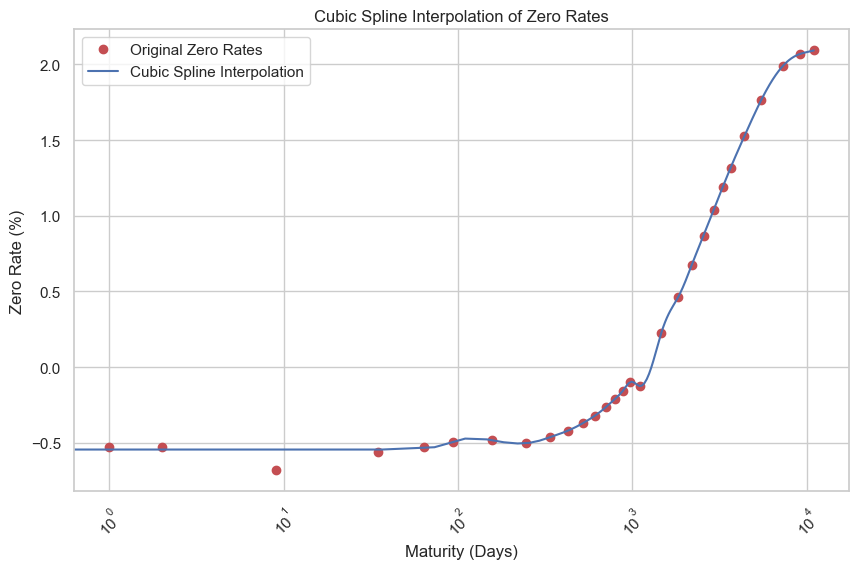

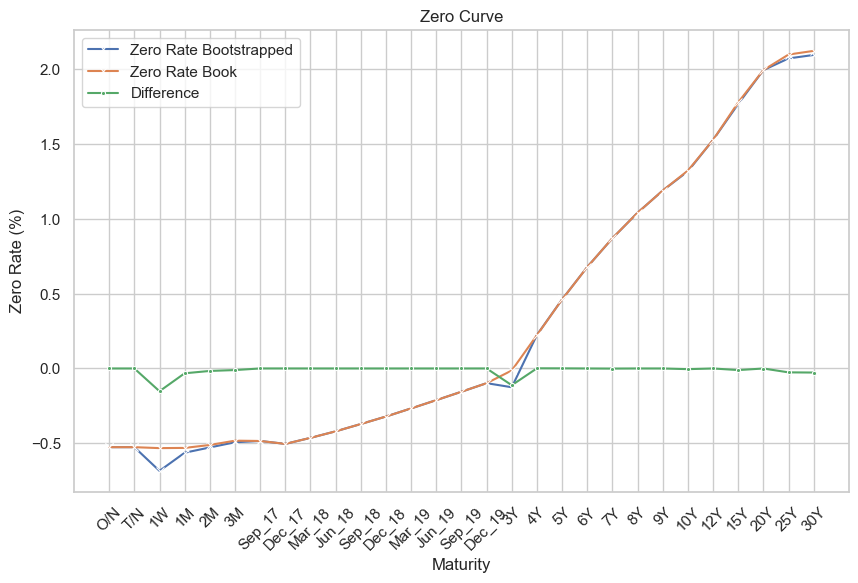

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import seaborn as sns

num_points = 300  
cs = CubicSpline(bootstrapped_data['Total Days'], bootstrapped_data['Zero Rate (%)'])
new_maturities = np.linspace(0, bootstrapped_data['Total Days'].max(), num_points)
interpolated_zero_rates = cs(new_maturities)

plt.figure(figsize=(10, 6))
plt.plot(bootstrapped_data['Total Days'], bootstrapped_data['Zero Rate (%)'], 'ro', label='Original Zero Rates')
plt.plot(new_maturities, interpolated_zero_rates, 'b-', label='Cubic Spline Interpolation')
plt.xlabel('Maturity (Days)')
plt.xticks(rotation=45)
plt.ylabel('Zero Rate (%)')
plt.xscale('log')
plt.title('Cubic Spline Interpolation of Zero Rates')
plt.legend()
plt.grid(True)
plt.show()

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.lineplot(x='Tenor', y='Zero Rate (%)', data=bootstrapped_data, marker='x', label='Zero Rate Bootstrapped')
sns.lineplot(x='Tenor', y='Zero Rate (%) Book', data=bootstrapped_data, marker='x', label='Zero Rate Book')
sns.lineplot(x='Tenor', y='Difference', data=bootstrapped_data, marker='.', label='Difference')
plt.xticks(rotation=45)
plt.title('Zero Curve') 
plt.xlabel('Maturity')
plt.ylabel('Zero Rate (%)')

plt.show()


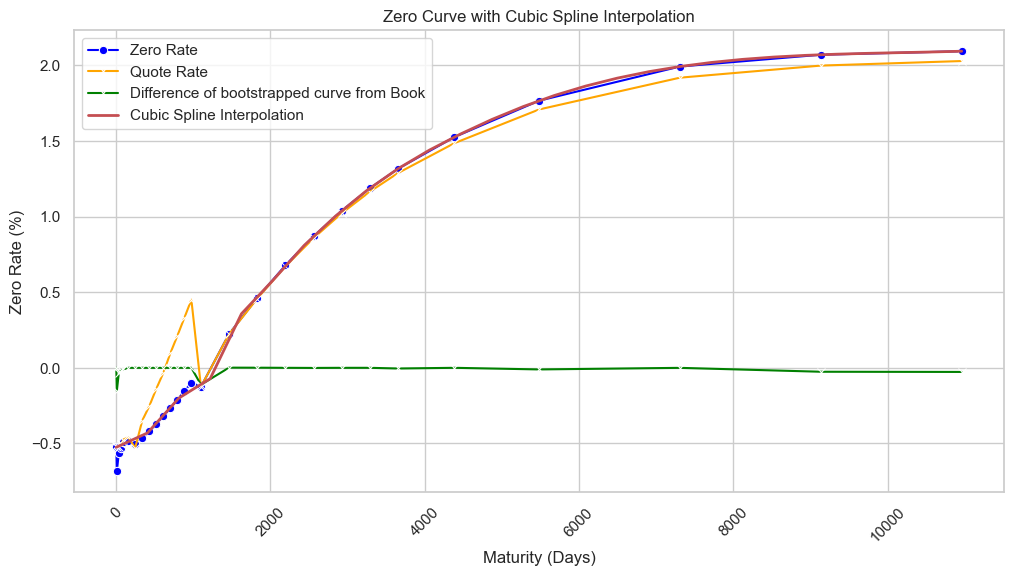

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import seaborn as sns

num_points = 28  # Number of points in the original dataset
cs = CubicSpline(bootstrapped_data['Total Days'], bootstrapped_data['Zero Rate (%)'])
new_maturities = np.linspace(bootstrapped_data['Total Days'].min(), bootstrapped_data['Total Days'].max(), num_points)
interpolated_zero_rates = cs(new_maturities)

plt.figure(figsize=(12, 6))

sns.lineplot(x=bootstrapped_data['Total Days'], y=bootstrapped_data['Zero Rate (%)'], marker='o', label='Zero Rate', color='blue')
sns.lineplot(x=bootstrapped_data['Total Days'], y=bootstrapped_data['Quote rate'], marker='x', label='Quote Rate', color='orange')
sns.lineplot(x=bootstrapped_data['Total Days'], y=bootstrapped_data['Difference'], marker='x', label='Difference of bootstrapped curve from Book', color='green')

plt.plot(new_maturities, interpolated_zero_rates, 'r-', label='Cubic Spline Interpolation', linewidth=2)

plt.xticks(rotation=45)
plt.title('Zero Curve with Cubic Spline Interpolation')
plt.xlabel('Maturity (Days)')
plt.ylabel('Zero Rate (%)')
plt.grid(True)
plt.legend()

plt.show()
